Estimating the value of a used car is one of the main everyday challenges in the automotive business. We believe that the sales price of a car is not only based on the value of the product itself, but is also heavily influenced by things like market trends, current availability, and politics.
With this challenge, we hope to raise some interest in this exciting topic and also gain some insight into what the main factors are that drive the value of a used car.

The data provided consists of almost 5000 real BMW cars that were sold via a b2b auction in 2018. The price shown in the table is the highest bid that was reached during the auction.

We have already done some data cleanup and filtered out cars with engine damage etc. However there may still be minor damages like scratches, but we do not have more information about that.

We have also extracted 8 criteria based on the equipment of cars that we think might have a good impact on the value of a used car. These criteria have been labeled feature1 to feature8 and are shown in the data below.

## 0. Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import bisect

import os
import operator
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/ING5/Deep Learning")
!ls

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive
data  figures


##  1. Reading data

In [ ]:
df = pd.read_csv("data/bmw_pricing_challenge.csv")

In [ ]:
df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


In [ ]:
df.shape

(4843, 18)

In [ ]:
df.describe()

,mileage,engine_power,price
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,15828.081767
std,6.019674e+04,38.99336,9220.285684
min,-6.400000e+01,0.00000,100.000000
25%,1.029135e+05,100.00000,10800.000000
50%,1.410800e+05,120.00000,14200.000000
75%,1.751955e+05,135.00000,18600.000000
max,1.000376e+06,423.00000,178500.000000


## 2. Exploratory Data Analysis

### 2.1. Missing Values

Check if the dataset contains any missing values.

In [ ]:
#print(df.shape)

df.isna().sum()

#print(df[df.mileage < 0])

df = df[df.mileage > 0]

print(df.shape)

(4842, 18)


### 2.2. Distribution of the target variable

Plot the distribution of the target variable.

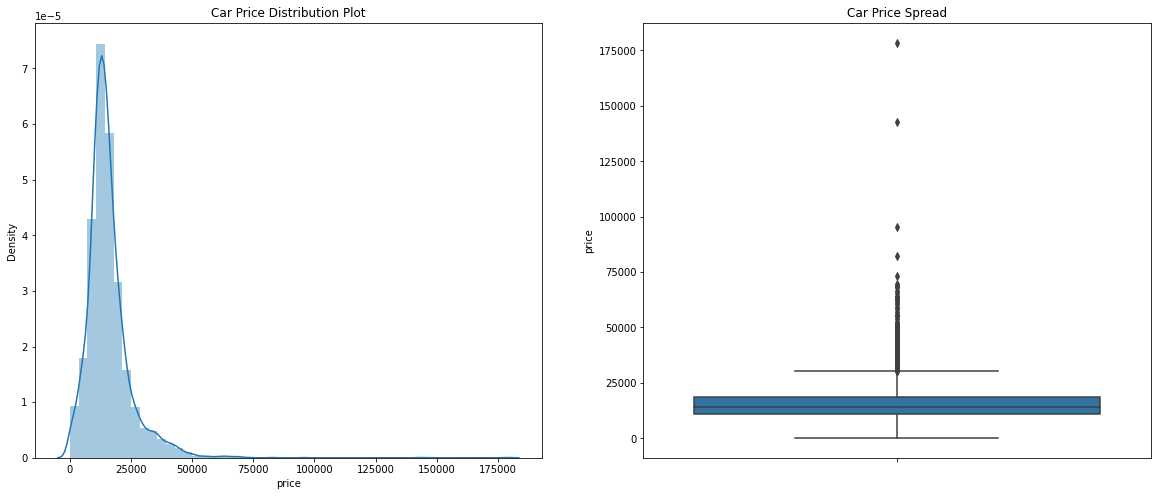

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(df.price)

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=df.price)

plt.show()

### 2.3. Distribution of numerical variables

Plot the distribution of the numerical features.

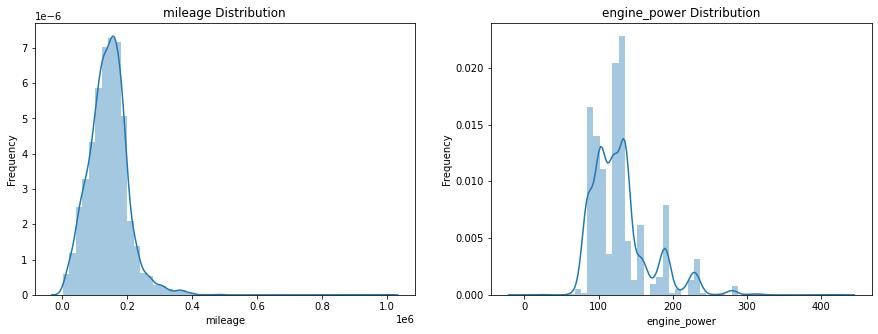

In [ ]:
num_cols = ['mileage', 'engine_power']
fig_rows = np.ceil(len(num_cols)/2)

plt.figure(figsize=(15, fig_rows*5))
plt.subplots_adjust(hspace=0.5)

for ind, col in enumerate(num_cols):
    plt.subplot(fig_rows,2,ind+1)
    plt.title(col+' Distribution')
    ax = sns.distplot(df[col])
    ax.set(xlabel = col, ylabel='Frequency')

### 2.4. Histogram of categorical variables

Plot the histogram of the categorical features.

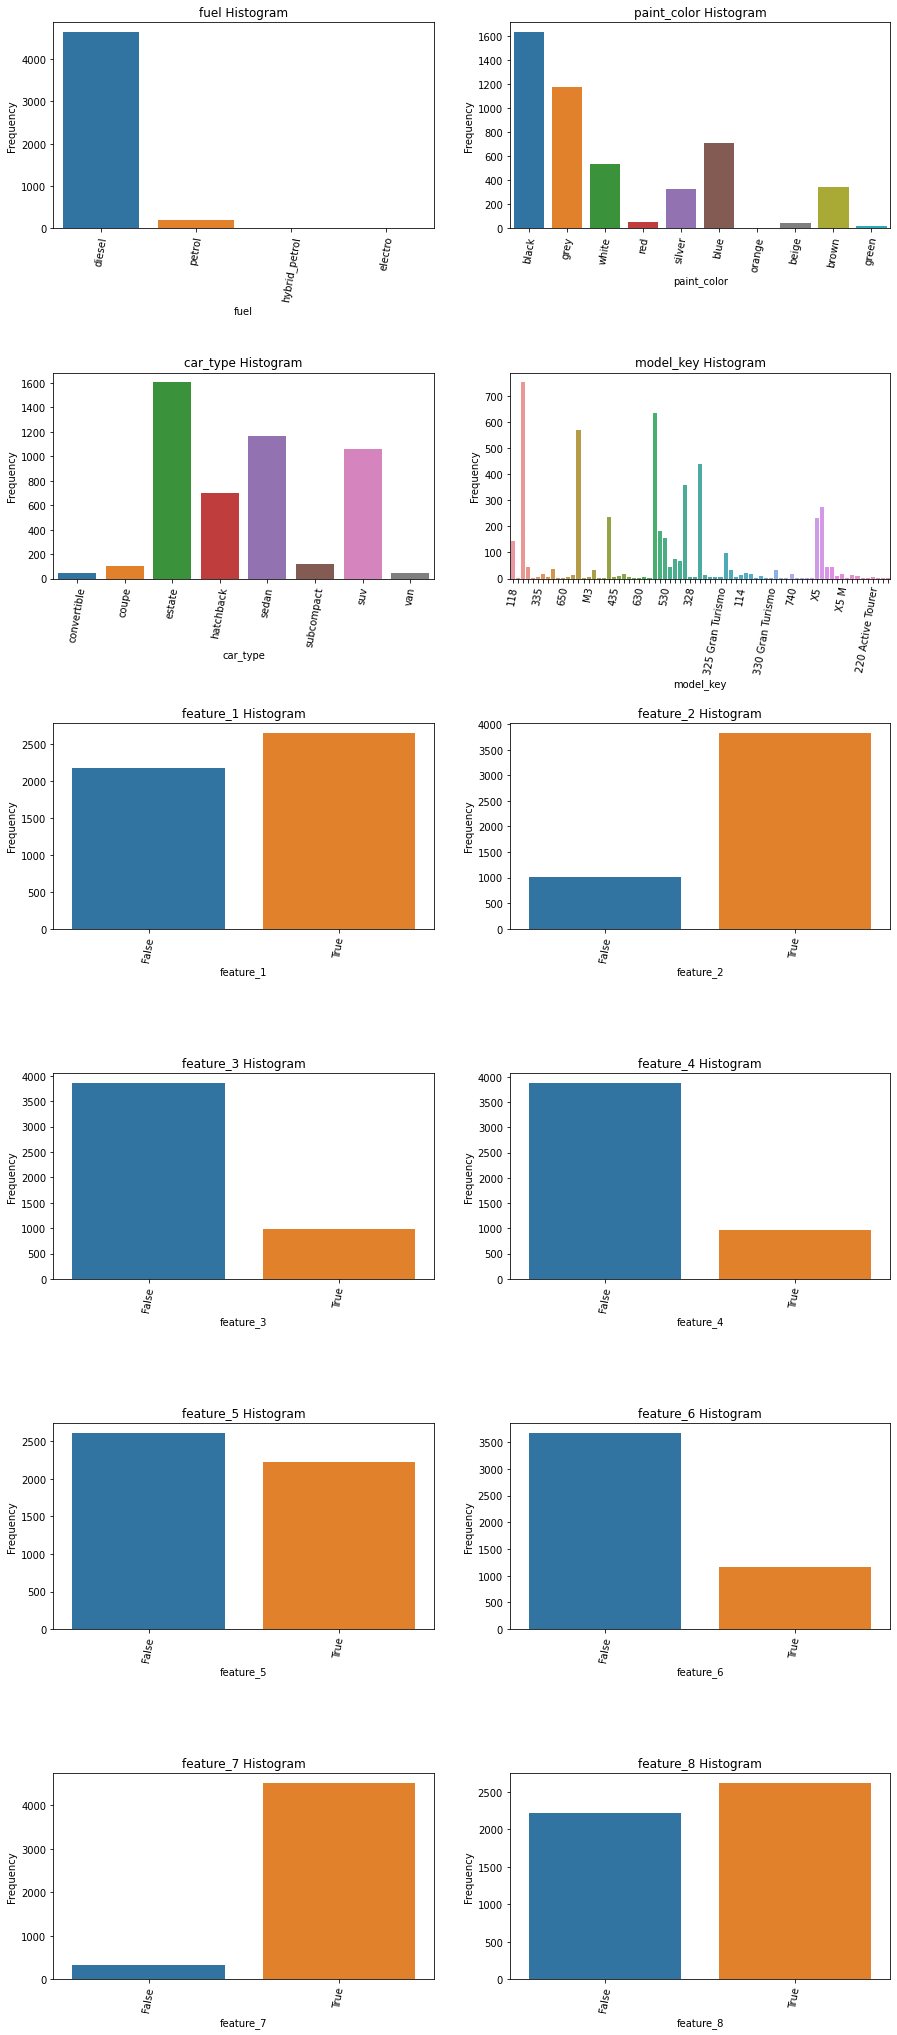

In [ ]:
cat_cols =['fuel', 'paint_color', 'car_type', 'model_key', 'feature_1',	'feature_2',	'feature_3',	'feature_4',	'feature_5',	'feature_6',	'feature_7', 'feature_8']
fig_rows = np.ceil(len(cat_cols)/2)

plt.figure(figsize=(15, fig_rows*6))
plt.subplots_adjust(hspace=0.7)

for ind, col in enumerate(cat_cols):
    plt.subplot(fig_rows,2,ind+1)
    plt.title(col+' Histogram')
    ax = sns.countplot(df[col])
    ax.set(xlabel = col, ylabel='Frequency')
    xtickslabels=ax.get_xticklabels()
    ax.set_xticklabels(xtickslabels, rotation=80)
    # reduce number of ticks when too many
    if(len(xtickslabels)>20):
        for ind, label in enumerate(xtickslabels):
            if ind % 5 == 0:  # every 5th label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)

## 3. Data Splitting

Split the dataset into 2 training and test datasets.

In [ ]:
y = df.pop("price")
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=8)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3389, 17)
(3389,)
(1453, 17)
(1453,)


## 4. Feature Engineering

### 4.1. Removing non-predictive features

Remove any unnecessary feature.

In [ ]:
X_train.drop(['maker_key', 'model_key', 'registration_date', 'paint_color', 'sold_at'], axis=1, inplace=True)
X_test.drop(['maker_key', 'model_key', 'registration_date', 'paint_color', 'sold_at'], axis=1, inplace=True)
print(X_train.shape)
print(X_test.shape)

(3389, 12)
(1453, 12)


### 4.2. Creating new features

Creating polynomial features for numerical columns

In [ ]:
num_cols = ['mileage', 'engine_power']

PF = PolynomialFeatures(degree=3, include_bias=False)

# Encode categorical columns, and store results in a new dataframe
X_train_poly = pd.DataFrame(PF.fit_transform(X_train[num_cols]), index=X_train.index)
X_test_poly = pd.DataFrame(PF.transform(X_test[num_cols]), index=X_test.index)

# Adding poly columns to initial datasets
poly_feature_names = PF.get_feature_names()
replace_dict = {"x"+str(i):num_cols[i] for i in range(2)}

for ind, name in replace_dict.items():
    poly_feature_names = [w.replace(ind, name) for w in poly_feature_names]
X_train_poly.columns = poly_feature_names
X_test_poly.columns = poly_feature_names

# Drop initial columns 
X_train.drop(num_cols ,axis=1, inplace=True)
X_test.drop(num_cols ,axis=1, inplace=True)
num_cols = poly_feature_names

# Add feature engineered columns to initial dataset
X_train = pd.concat([X_train, X_train_poly], axis=1)
X_test = pd.concat([X_test, X_test_poly ], axis=1) 

### 4.3. Scaling numerical variables

In [ ]:
SS = StandardScaler()
scaled_cols = num_cols 

X_train[scaled_cols] = SS.fit_transform(X_train[scaled_cols])
X_test[scaled_cols] = SS.transform(X_test[scaled_cols])

X_train.dtypes

X_train.head()

,fuel,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,mileage,engine_power,mileage^2,mileage engine_power,engine_power^2,mileage^3,mileage^2 engine_power,mileage engine_power^2,engine_power^3
161,diesel,estate,True,True,False,False,False,False,True,False,1.752337,-0.231600,1.447922,1.236238,-0.299044,0.565744,1.389694,0.524014,-0.306839
754,diesel,estate,True,True,True,False,True,False,True,True,0.050301,-0.231600,-0.108538,-0.086400,-0.299044,-0.091026,-0.166942,-0.222103,-0.306839
1460,diesel,estate,True,True,False,False,False,False,True,True,0.344430,-0.231600,0.101623,0.142165,-0.299044,-0.023235,0.043243,-0.093167,-0.306839
2729,diesel,sedan,True,True,False,False,True,True,True,True,-0.849529,2.324134,-0.598906,0.165442,2.385112,-0.213736,-0.402051,0.903591,2.174393
4456,diesel,suv,False,True,True,True,True,True,True,False,0.303530,0.023974,0.070929,0.280161,-0.101680,-0.033623,0.093902,0.088434,-0.176379


### 4.4. Categorical variables encoding

Convert categorical columns into numerical columns using label encoding or one-hot encoding.

In [ ]:
OHE = OneHotEncoder(drop = None, handle_unknown='ignore', sparse=False)

# Define categorical to be one hot encoded
ohe_cols = ['fuel', 'car_type']

# Encode categorical columns, and store results in a new dataframe
X_train_encoded = pd.DataFrame(OHE.fit_transform(X_train[ohe_cols]), index=X_train.index)
X_test_encoded = pd.DataFrame(OHE.transform(X_test[ohe_cols]), index=X_test.index)

# Retrieve encoded columns names
X_train_encoded.columns = OHE.get_feature_names(ohe_cols)
X_test_encoded.columns = OHE.get_feature_names(ohe_cols)

# Drop initial columns 
X_train.drop(ohe_cols ,axis=1, inplace=True)
X_test.drop(ohe_cols ,axis=1, inplace=True)

# Add encoded columns to initial dataset
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded ], axis=1)

### 4.5. Converting boolean columns

In [ ]:
X_train["feature_1"] = X_train["feature_1"].astype(int)
X_train["feature_2"] = X_train["feature_2"].astype(int)
X_train["feature_3"] = X_train["feature_3"].astype(int)
X_train["feature_4"] = X_train["feature_4"].astype(int)
X_train["feature_5"] = X_train["feature_5"].astype(int)
X_train["feature_6"] = X_train["feature_6"].astype(int)
X_train["feature_7"] = X_train["feature_7"].astype(int)
X_train["feature_8"] = X_train["feature_8"].astype(int)
X_test["feature_1"] = X_test["feature_1"].astype(int)
X_test["feature_2"] = X_test["feature_2"].astype(int)
X_test["feature_3"] = X_test["feature_3"].astype(int)
X_test["feature_4"] = X_test["feature_4"].astype(int)
X_test["feature_5"] = X_test["feature_5"].astype(int)
X_test["feature_6"] = X_test["feature_6"].astype(int)
X_test["feature_7"] = X_test["feature_7"].astype(int)
X_test["feature_8"] = X_test["feature_8"].astype(int)

## 5. Linear Regression

Fit a linear regression model on the training set. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

In [ ]:
# fit linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predicting over training & testing datasets
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

importance = lr.coef_


rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 4889.653284474364
R2 score is 0.6997576800088686


The model performance for testing set
--------------------------------------
RMSE is 5982.855083429508
R2 score is 0.6237126227138254


Plot feature importance/weight.

Feature: 0, Score: 699.76085
Feature: 1, Score: 2491.40668
Feature: 2, Score: 522.90629
Feature: 3, Score: 1538.73795
Feature: 4, Score: 646.99062
Feature: 5, Score: 1188.71731
Feature: 6, Score: 198.04455
Feature: 7, Score: 2817.34931
Feature: 8, Score: 2925.99209
Feature: 9, Score: 3795.12495
Feature: 10, Score: -1721.93577
Feature: 11, Score: -11047.73719
Feature: 12, Score: 6690.16502
Feature: 13, Score: -707.56820
Feature: 14, Score: 5000.02738
Feature: 15, Score: 1001.70361
Feature: 16, Score: -2869.03476
Feature: 17, Score: -2939.90860
Feature: 18, Score: -605.19881
Feature: 19, Score: 11745.94042
Feature: 20, Score: -8200.83301
Feature: 21, Score: 146.03379
Feature: 22, Score: 1335.55081
Feature: 23, Score: -1441.43083
Feature: 24, Score: -313.44793
Feature: 25, Score: 302.79216
Feature: 26, Score: -236.18242
Feature: 27, Score: 1953.03840
Feature: 28, Score: -1746.35398


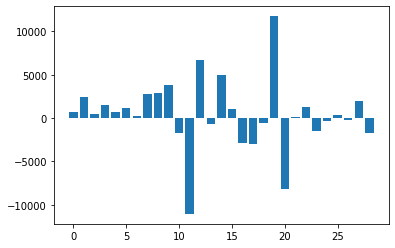

In [ ]:
from matplotlib import pyplot
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()


## 6. Ridge

Fit a ridge regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

In [ ]:
## training the model
param_grid = {'alpha': [10**i for i in np.arange(-4, 4,  0.2, dtype=float)]}

ridge = Ridge(normalize=False)
ridge_search = GridSearchCV(ridge, param_grid, scoring='r2', cv=5)
ridge_search.fit(X_train, y_train)

ridge.fit(X_train, y_train)
importance = ridge.coef_

# predicting over training & testing datasets
y_train_pred = ridge_search.predict(X_train)
y_test_pred = ridge_search.predict(X_test)


# model evaluation for training set
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 4906.986486222537
R2 score is 0.697625265112432


The model performance for testing set
--------------------------------------
RMSE is 5991.015140386948
R2 score is 0.6226854808746296


Plot feature importance/weight.

In [ ]:
ridge_search.best_estimator_

Ridge(alpha=6.309573444801995, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

Feature: 0, Score: 705.66978
Feature: 1, Score: 2495.01383
Feature: 2, Score: 524.19873
Feature: 3, Score: 1549.53134
Feature: 4, Score: 636.63712
Feature: 5, Score: 1185.57763
Feature: 6, Score: 185.78358
Feature: 7, Score: 2815.23652
Feature: 8, Score: 1689.23571
Feature: 9, Score: 3414.70000
Feature: 10, Score: -522.45168
Feature: 11, Score: -9234.97430
Feature: 12, Score: 6542.02410
Feature: 13, Score: -954.57981
Feature: 14, Score: 4039.99265
Feature: 15, Score: 393.39821
Feature: 16, Score: -2565.47201
Feature: 17, Score: -2439.27569
Feature: 18, Score: -186.89697
Feature: 19, Score: 10270.97523
Feature: 20, Score: -7644.80257
Feature: 21, Score: 122.08170
Feature: 22, Score: 1357.29824
Feature: 23, Score: -1446.19667
Feature: 24, Score: -307.42078
Feature: 25, Score: 305.64404
Feature: 26, Score: -216.30295
Feature: 27, Score: 1948.86681
Feature: 28, Score: -1763.97039


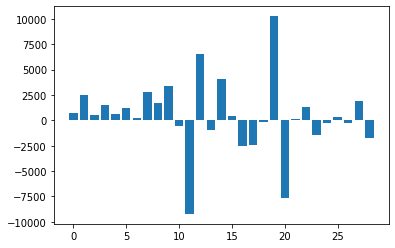

In [ ]:
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## 7. Lasso

Fit a lasso regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

In [ ]:
## training the model
param_grid = {'alpha': [10**i for i in np.arange(-4, 4,  0.5, dtype=float)]}

lasso = Lasso(normalize=False)
lasso_search = GridSearchCV(lasso, param_grid, scoring='r2', cv=5)
lasso_search.fit(X_train, y_train)

lasso.fit(X_train, y_train)
importance = lasso.coef_

# predicting over training & testing datasets
y_train_pred = lasso_search.predict(X_train)
y_test_pred = lasso_search.predict(X_test)

# model evaluation for training set
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)


print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 4971.487221370766
R2 score is 0.6896237857482701


The model performance for testing set
--------------------------------------
RMSE is 6031.921666559017
R2 score is 0.6175152986796162


Plot feature importance/weight.

In [ ]:
lasso_search.best_estimator_

Lasso(alpha=31.622776601683793, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Feature: 0, Score: 708.20866
Feature: 1, Score: 2495.87039
Feature: 2, Score: 511.91922
Feature: 3, Score: 1538.79169
Feature: 4, Score: 645.68115
Feature: 5, Score: 1187.25427
Feature: 6, Score: 160.05033
Feature: 7, Score: 2820.38722
Feature: 8, Score: 1354.17241
Feature: 9, Score: 2561.75962
Feature: 10, Score: -368.12705
Feature: 11, Score: -8608.53776
Feature: 12, Score: 7867.55504
Feature: 13, Score: -986.11876
Feature: 14, Score: 3925.17388
Feature: 15, Score: 29.36293
Feature: 16, Score: -3084.14342
Feature: 17, Score: -0.78744
Feature: 18, Score: 396.71004
Feature: 19, Score: 14008.16157
Feature: 20, Score: -5240.68785
Feature: 21, Score: 5.21955
Feature: 22, Score: 1280.14857
Feature: 23, Score: -1475.04590
Feature: 24, Score: -346.00030
Feature: 25, Score: 271.37157
Feature: 26, Score: -262.30921
Feature: 27, Score: 1909.92541
Feature: 28, Score: -1769.72244


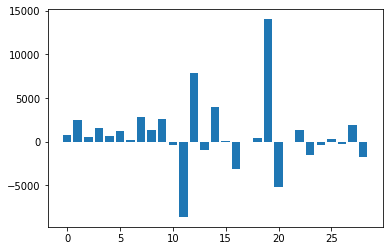

In [ ]:
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()